In [1]:
import cantera as ct
import numpy as np
import pandas as pd
import math 
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Load in data from paper:  
note: RWGS rates are the yield of CO. 

Yang, Yixiong, Jaime Evans, Jose A. Rodriguez, Michael G. White, and Ping Liu. “Fundamental Studies of Methanol Synthesis from CO2 Hydrogenation on Cu(111), Cu Clusters, and Cu/ZnO(0001̄).” Physical Chemistry Chemical Physics 12, no. 33 (2010): 9909. https://doi.org/10.1039/c001484b.

<img src="images/MeOH_and_RWGS_arrhenius.png" width=400 height=400 />

### A note from Ray Speth on getting the indices for rops: 
Note that you shouldn't rely on that specific ordering of the phases. It can vary depending on how the interface kinetics object is instantiated (for example, using a YAML file instead of a CTI/XML file). You should use the ```phase_index```  and ```kinetics_species_index``` functions to find out how the species are arranged. For example, ```surf.kinetics_species_index(0, surf.phase_index(surf))``` will give you the index of the first surface species in the ```net_production_rates array```, while ```surf.kinetics_species_index(0, surf.phase_index(gas))``` will give you the index of the first gas phase species. You can also use the list returned by ```surf.kinetics_species_names```, which corresponds to the ```net_production_rates``` array.

In [2]:
# Load in values from plot above
# we already know 
temp = [525, 550, 575, 600]

meoh_ln_rate = [
    -6.691144708,
    -5.978401728,
    -4.48812095,
    -3.894168467,
]

rwgs_ln_rate = [
    -0.578342066,
    0.572607525,
    1.171517945,
    2.072487534,
]

# convert to molecules/cm^2/sec
meoh_rates_cm = np.exp(meoh_ln_rate)*10**15
meoh_rates = dict(zip(temp, meoh_rates_cm))

rwgs_rates_cm = np.exp(rwgs_ln_rate)*10**15
rwgs_rates = dict(zip(temp, rwgs_rates_cm))
"{:2e}".format(meoh_rates[525])

'1.241860e+12'

They reported the following rates at 575K for Methanol and water TOF, so we'll use these to guess their site density (although it is probably irrelevant for our simulation). 

Methanol rate ($s^{-1}$) = 6.3e-3  
RWGS rate ($s^{-1}$)     = 1.8  

we used these to reverse-calculate the surface area ($\Gamma$, $\frac{molecules}{cm^{2}}$):   
$r_{TOF}$ ($s^{-1}$) = $r$ ($\frac{molec}{cm^{2}s})$ * $\frac{1}{\Gamma}$  
$\Gamma$ = $\frac{rate}{rate_{TOF}}$

In [3]:
meoh_rate_tof = 6.3e-3
rwgs_rate_tof = 1.8
meoh_rate_cm = meoh_rates[575]
rwgs_rate_cm = rwgs_rates[575]
site_density = np.mean([meoh_rate_cm/meoh_rate_tof, rwgs_rate_cm/rwgs_rate_tof])
"site density molecules/cm: {:2e}".format(site_density)

'site density molecules/cm: 1.788560e+15'

### get meoh rates in turn over frequency so it is easier

In [4]:
meoh_rates_tof = {temp:rate/site_density for temp,rate in meoh_rates.items()}
meoh_rates_tof

{525: 0.0006943354237582917,
 550: 0.001416151334630445,
 575: 0.006285363285118115,
 600: 0.011383627345307495}

### get rwgs rates in turn over frequency

In [5]:
rwgs_rates_tof = {temp:rate/site_density for temp,rate in rwgs_rates.items()}
rwgs_rates_tof

{525: 0.3135636990826555,
 550: 0.9912354726941712,
 575: 1.8041819185376813,
 600: 4.441876166963712}

## create a batch reactor 
The configuration for the one used by yang resembles the reactor proposed by yang

### Inputs
0.5 atm CO2  
4.5 atm H2  


In [6]:
# convert to pascals
p_co2 = 0.5 * ct.one_atm
p_h2 =  4.5 * ct.one_atm
p_total = p_co2+p_h2

# get total pressure at temp using ig law pv = nrt
initial_temp = 300 #[k]
p_total_at_temp = np.array(temp)*p_total/initial_temp

x_co2 = p_co2/p_total
x_h2 = p_h2/p_total

print(x_h2, x_co2, p_total)
print(temp, p_total_at_temp)

0.9 0.1 506625.0
[525, 550, 575, 600] [ 886593.75  928812.5   971031.25 1013250.  ]


### Surface area $m^2$

In [7]:
cat_area = 1e2

In [8]:
# create thermo phases
toy_mech = False

if toy_mech: 
    yaml_gas = "../RMG_model_analysis/test_gas.yaml"
    yaml_surf = "../RMG_model_analysis/test_surf.yaml"
    
    gas = ct.Solution(yaml_surf, "gas")
    surf = ct.Interface(yaml_surf,"surface1", [gas])
    surf.coverages = {'X':1.0}
    
    for name in gas.species_names:
        if name.startswith("CO2"):
            co2_str = name
        if name.startswith("H2"):
            h2_str = name
        if name.startswith("CH3OH"):
            meoh_str = name
else: 
#     yaml_file = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/cantera/chem_annotated.cti"
    yaml_file = "/work/westgroup/ChrisB/_01_MeOH_repos/RMG_run_comparisons/bep_parameter_study/rmg_runs/meoh_bjarne_bep/base/cantera/chem_annotated.cti"
    gas = ct.Solution(yaml_file, "gas")
    surf = ct.Interface(yaml_file,"surface1", [gas])
    
    for name in gas.species_names:
        if name.startswith("CO2("):
            co2_str = name
        if name.startswith("H2("):
            h2_str = name
        if name.startswith("CH3OH("):
            meoh_str = name

            
mole_fractions = {co2_str:x_co2,h2_str:x_h2}
# molecular weights for mass flow calculations
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3  # [kg/mol]
mw_h2 = 2.016e-3  # [kg/mol]
mw_h2o = 18.01528e-3  # [kg/mol]

gas.TPX = temp[0], p_total_at_temp[0], mole_fractions
surf.TP = temp[0], p_total_at_temp[0]

r = ct.IdealGasReactor(gas, energy="off")
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
# initialize reactor network
sim = ct.ReactorNet([r])
sim.atol = 1e-16
sim.rtol = 1e-14

In [9]:
reactime = 200*60
t = 0
dt = 5.0
conversion = 0 

nspecies = len(gas.species_names)
meoh_gas_index = gas.kinetics_species_index(meoh_str)
meoh_surf_index = surf.kinetics_species_index(meoh_str)

meoh_rop = []  
meoh_moles_norm = []
temps = []
press = []
times = []
conversions = []
r.volume = 0.1

# see if the Rop is constant
while t < reactime and conversion < 0.05:
    t += dt
    sim.advance(t)
    meoh_total_rop = gas.net_production_rates[meoh_gas_index] + surf.net_production_rates[meoh_surf_index]
    meoh_total_rop = meoh_total_rop/surf.site_density
    meoh_rop.append(meoh_total_rop)
    times.append(sim.time) # time in minutes
    temps.append(gas.T)
    press.append(gas.P)
    
    moles_co2_initial = p_co2*r.volume/(ct.gas_constant*initial_temp) # Pco2*v/RT
    moles_meoh = (gas[meoh_str].X*gas.P*r.volume)/(ct.gas_constant*gas.T) # mole frac*total moles
    moles_co2 = (gas[co2_str].X*gas.P*r.volume)/(ct.gas_constant*gas.T) # mole frac*total moles
        
        
    # calculate conversion:
    # (moles meoh possible (starting moles co2)-moles meoh current)/moles co2 initial
    conversion = (moles_co2_initial - moles_co2)/moles_co2_initial
    
    conversions.append(conversion)
    
    # calculate the moles methanol normalized
    # to the number of surface sites
    meoh_moles_norm.append(float(moles_meoh/(surf.site_density*cat_area))) 

In [10]:
dict(zip(gas.species_names, gas.X))

{'N2': 0.0,
 'Ne': 0.0,
 'H2(2)': 0.8889077030970296,
 'CO(3)': 4.177827704010003e-05,
 'CO2(4)': 0.09594673942165738,
 'H2O(5)': 0.010083642152393725,
 'CH3OH(6)': 4.869147390351992e-07,
 'CH4(24)': 0.005019436710939741,
 'CH2O(37)': 5.1523923982151074e-11,
 'CH2O2(39)': 2.1337449435135007e-07,
 'C2H4O(243)': 8.772183581765387e-15,
 'CCO(335)': 1.732845508310836e-13}

In [11]:
surf.TP = 525, surf.P
surf.equilibrate('TP')
dict(zip(surf.species_names, surf.X))

{'X(1)': 0.6074225510427302,
 'HX(15)': 0.011993305278096179,
 'OX(16)': 3.2070845468011555e-11,
 'OCX(17)': 5.544318604160657e-16,
 'HOX(19)': 2.2697152178442156e-13,
 'CO2X(20)': 3.2236487238676737e-20,
 'CXHO(22)': 4.415322067068993e-18,
 'HOCXO(23)': 4.998542016685044e-25,
 'CH3X(25)': 1.0054712878404106e-13,
 'H2OX(26)': 0.00013544562902260323,
 'H2X(32)': 0.3718247535832447,
 'CH3OX(34)': 6.989000433309765e-24,
 'CH3OX(35)': 3.896535618476417e-18,
 'CH4OX(36)': 1.605878755394872e-17,
 'CHO2X(50)': 1.1335180686574873e-25,
 'COX2(52)': 7.275660090738619e-19,
 'CH2OX(63)': 7.2535729999142325e-19,
 'CHOX2(75)': 2.1484727492371346e-26,
 'CH2OX2(99)': 4.515585278165104e-26,
 'SX(103)': 1.053307691130658e-36,
 'SX(139)': 2.9411021703522727e-35,
 'SX(146)': 2.581248206203385e-31,
 'SX(151)': 1.7675083681222098e-39,
 'CH4X(160)': 0.008623944434507334,
 'SX(163)': 3.4942146950497584e-23,
 'SX(167)': 1.8080476121110756e-34,
 'SX(173)': 6.609972873170103e-25,
 'SX(177)': 1.219877862779419e-3

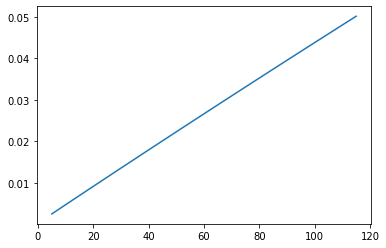

In [12]:
# normalize by site
plt.plot(times,conversions)

conversion from kmoles meoh to molecule/s (TOF)

$N_{MeOH}[kmol]*\frac{1}{\Gamma} \left[\frac{m^2}{kmol}\right] *\frac{1}{Area} \left[\frac{1}{m^2}\right]* \frac{1}{time}\left[\frac{1}{s}\right] = TOF \left[\frac{1}{s}\right]$ 

In [13]:
x1 = times[0]
x2 = times[-1]
y1 = meoh_moles_norm[0]
y2 = meoh_moles_norm[-1]
slope = (y1-y2)/(x1-x2)
print(slope)

-1.2667541237291353e-06


In [14]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(times,meoh_moles_norm)
print(
    "slope: ", slope,
    "\nintercept: ", intercept, 
    "\nr^2 value: ", r_value**2, 
    "\np value: ", p_value, 
    "\nstd error: ", std_err 
)

slope:  -1.266681692529301e-06 
intercept:  0.003471902425504385 
r^2 value:  0.9999480403482989 
p value:  1.7789671159213306e-46 
std error:  1.992517961986426e-09


## run multiple times and see if they are close. 

In [15]:
import cantera as ct
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

525
iteration 0
2400 2400
slope:  5.843346660770979e-06 
intercept:  -1.0505146657939762e-05 
r^2 value:  0.9999661424285359 
p value:  0.0 
std error:  6.943402102966093e-10


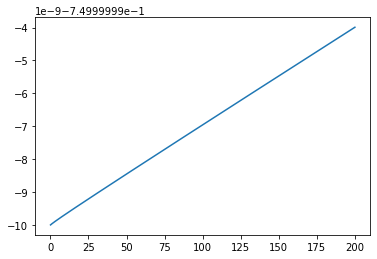

550
iteration 1
2400 2400
slope:  6.035826726779019e-06 
intercept:  -1.0687170208270006e-05 
r^2 value:  0.9999672106934859 
p value:  0.0 
std error:  7.058061047680285e-10


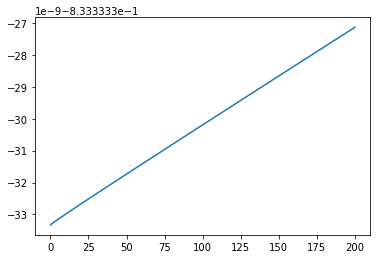

575
iteration 2
2400 2400
slope:  6.2237757504673055e-06 
intercept:  -1.0862048938039322e-05 
r^2 value:  0.9999681922661239 
p value:  0.0 
std error:  7.168076282258978e-10


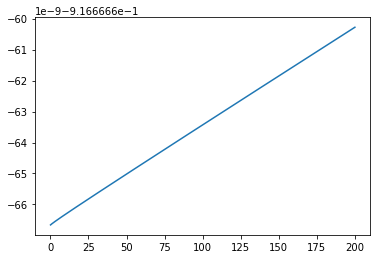

600
iteration 3
2400 2400
slope:  6.407470882669093e-06 
intercept:  -1.1030374213582845e-05 
r^2 value:  0.9999690977442408 
p value:  0.0 
std error:  7.273841839992409e-10


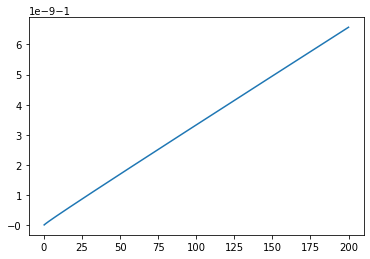

In [16]:
# load initial data from yang 2010
t_mult = 1.0
p_mult = 1e0
temp = [525, 550, 575, 600]
modified_temps = [
    525*t_mult, 
    550*t_mult, 
    575*t_mult, 
    600*t_mult
]
meoh_ln_rate = [
    -6.691144708,
    -5.978401728,
    -4.48812095,
    -3.894168467,
]

rwgs_ln_rate = [
    -0.578342066,
    0.572607525,
    1.171517945,
    2.072487534,
]

# convert to molecules/cm^2/sec
meoh_rates_cm = np.exp(meoh_ln_rate)*10**15
meoh_rates = dict(zip(temp, meoh_rates_cm))

rwgs_rates_cm = np.exp(rwgs_ln_rate)*10**15
rwgs_rates = dict(zip(temp, rwgs_rates_cm))

# get yang site density from reported rates
meoh_rate_tof = 6.3e-3
rwgs_rate_tof = 1.8
meoh_rate_cm = meoh_rates[575]
rwgs_rate_cm = rwgs_rates[575]
yang_site_density = np.mean([meoh_rate_cm/meoh_rate_tof, rwgs_rate_cm/rwgs_rate_tof])

# yang TOFs
meoh_rates_tof = {temp:rate/yang_site_density for temp,rate in meoh_rates.items()}
rwgs_rates_tof = {temp:rate/yang_site_density for temp,rate in rwgs_rates.items()}

# convert yang pressures to pascals
p_co2 = 0.5 * ct.one_atm*p_mult
p_h2 =  4.5 * ct.one_atm*p_mult
p_total = p_co2+p_h2

# get total pressure at initial CO2/H2 temp using ig law pv = nrt
initial_temp = 300 #[k]
p_total_at_temp = np.array(temp)*p_total/initial_temp

x_co2 = p_co2/p_total
x_h2 = p_h2/p_total

# create thermo phases
toy_mech = False

# specify cat area. should be somewhat arbitrary but test to be sure.
# set to 1cm^2 per campbell paper
cat_area = 1e-4


if toy_mech: 
    yaml_file = "../../External_data/park_et_al_model_reconstruction/park_mech.cti"

    gas = ct.Solution(yaml_file, "gas")
    surf = ct.Interface(yaml_file,"surface1", [gas])
    surf.coverages = {'*':1.0}

    for name in gas.species_names:
        if name.startswith("CO2"):
            co2_str = name
        if name.startswith("H2"):
            h2_str = name
        if name.startswith("CH3OH"):
            meoh_str = name
    surf_site_str = '*'
else: 
    yaml_file = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/cantera/chem_annotated.cti"
    gas = ct.Solution(yaml_file, "gas")
    surf = ct.Interface(yaml_file,"surface1", [gas])

    for name in gas.species_names:
        if name.startswith("CO2("):
            co2_str = name
        if name.startswith("H2("):
            h2_str = name
        if name.startswith("CH3OH("):
            meoh_str = name
    surf_site_str = 'X(1)'


mole_fractions = {co2_str:x_co2,h2_str:x_h2}

# molecular weights for mass flow calculations
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3  # [kg/mol]
mw_h2 = 2.016e-3  # [kg/mol]
mw_h2o = 18.01528e-3  # [kg/mol]

# run the yang batch reactor
nspecies = len(gas.species_names)
meoh_gas_index = gas.kinetics_species_index(meoh_str)
meoh_surf_index = surf.kinetics_species_index(meoh_str)

# data from all runs 
meoh_rop_dict = {}  
meoh_moles_norm_dict = {}
temps_dict = {}
press_dict = {}
times_dict = {}
conversions_dict = {}
meoh_slope_dict = {}

reactime = 200*60
dt = 5.0

for i in range(len(temp)):
    print(temp[i])
    print("iteration", i)
    
    # data for this run
    meoh_rop = []  
    meoh_moles_norm = []
    temps = []
    press = []
    times = []
    conversions = []
    
    # get total pressure at initial CO2/H2 temp using ig law pv = nrt
    initial_temp = 300 #[k]
    p_total_at_temp = np.array(temp)*p_total/initial_temp

    x_co2 = p_co2/p_total
    x_h2 = p_h2/p_total

    # set the thermophase (maybe there is a faster way to set this up each time)
#     gas.TPX = temp[i], p_total_at_temp[i], mole_fractions
    gas.TPX = 300, p_total_at_temp[i], mole_fractions
    surf.TP = temp[i], p_total_at_temp[i]
    surf.coverages = {surf_site_str:1.0}
    r = ct.IdealGasReactor(gas, energy="off")
    r.volume = 3e-5 # from cambell at al paper, 30 mL microreactor? 
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # initialize reactor network
    sim = ct.ReactorNet([r])
    sim.atol = 1e-15
    sim.rtol = 1e-13

    # see if the Rop is constant
    conversion = 0
    t = 0
    while t < reactime and conversion < 0.05:
        t += dt
        sim.advance(t)
        meoh_total_rop = gas.net_production_rates[meoh_gas_index] + surf.net_production_rates[meoh_surf_index]
        meoh_total_rop = meoh_total_rop/surf.site_density
        meoh_rop.append(meoh_total_rop)
        times.append(sim.time/60) # time in minutes
        temps.append(gas.T)
        press.append(gas.P)

        moles_co2_initial = p_co2*r.volume/(ct.gas_constant*initial_temp) # Pco2*v/RT
        moles_meoh = (gas[meoh_str].X*gas.P*r.volume)/(ct.gas_constant*gas.T) # mole frac*total moles
        moles_co2 = (gas[co2_str].X*gas.P*r.volume)/(ct.gas_constant*gas.T) # mole frac*total moles
        
        
        # calculate conversion:
        # (moles meoh possible (starting moles co2)-moles meoh current)/moles co2 initial
        conversion = (moles_co2_initial - moles_co2)/moles_co2_initial
        conversions.append(conversion)

        # calculate the moles methanol normalized
        # to the number of surface sites
        meoh_moles_norm.append(float(moles_meoh/(surf.site_density*cat_area))) 

    meoh_rop_dict[temp[i]] = meoh_rop
    meoh_moles_norm_dict[temp[i]] = meoh_moles_norm
    temps_dict[temp[i]] = temps
    press_dict[temp[i]] = press
    times_dict[temp[i]] = times
    conversions_dict[temp[i]] = conversions

    print(len(times), len(meoh_moles_norm))
    meoh_slope, intercept, r_value, p_value, std_err = stats.linregress(times,meoh_moles_norm)
    meoh_slope_dict[temp[i]] = meoh_slope
    print(
        "slope: ", meoh_slope,
        "\nintercept: ", intercept, 
        "\nr^2 value: ", r_value**2, 
        "\np value: ", p_value, 
        "\nstd error: ", std_err 
    )
    plt.plot(times,conversions)
    plt.show()

    
# build_and_run_yang()

In [17]:
meoh_slope_dict

{525: 5.843346660770979e-06,
 550: 6.035826726779019e-06,
 575: 6.2237757504673055e-06,
 600: 6.407470882669093e-06}

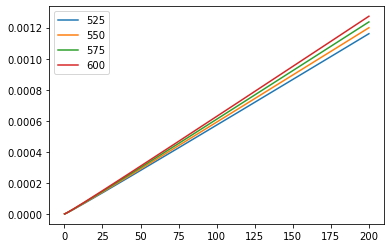

In [18]:
plt.plot(times_dict[525],meoh_moles_norm_dict[525], label = 525)
plt.plot(times_dict[550],meoh_moles_norm_dict[550], label = 550)
plt.plot(times_dict[575],meoh_moles_norm_dict[575], label = 575)
plt.plot(times_dict[600],meoh_moles_norm_dict[600], label = 600)
plt.legend()

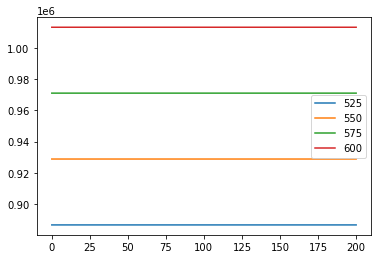

In [19]:
plt.plot(times_dict[525],press_dict[525], label = 525)
plt.plot(times_dict[550],press_dict[550], label = 550)
plt.plot(times_dict[575],press_dict[575], label = 575)
plt.plot(times_dict[600],press_dict[600], label = 600)
plt.legend()

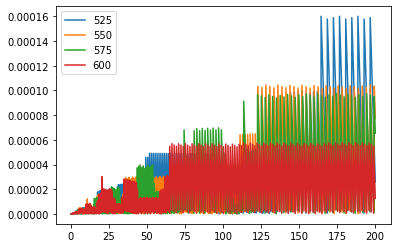

In [20]:
plt.plot(times_dict[525],meoh_rop_dict[525], label = 525)
plt.plot(times_dict[550],meoh_rop_dict[550], label = 550)
plt.plot(times_dict[575],meoh_rop_dict[575], label = 575)
plt.plot(times_dict[600],meoh_rop_dict[600], label = 600)
plt.legend()

## baseline model has negative temperature dependence for rate vs temp (rate decreases as temp increases).

In [21]:
dict(zip(gas.species_names, gas.X))

{'N2': 0.0,
 'Ne': 0.0,
 'H2(2)': 0.8999999796713123,
 'CO(3)': 2.086425205675977e-11,
 'CO2(4)': 0.10000001967179774,
 'H2O(5)': 3.28508263917899e-10,
 'CH2O(6)': 2.8321776735581146e-20,
 'HCOOH(7)': 4.3773833935719554e-15,
 'CH3OH(8)': 3.0751334387184664e-10,
 'HCOOCH3(9)': 4.369610990297018e-23,
 'CH4(24)': 6.409028557539884e-45}

In [22]:
dict(zip(surf.species_names, surf.X))

{'X(1)': 0.16340081010601054,
 'H*(10)': 0.021911470254290827,
 'O*(11)': 4.3485383596462435e-10,
 'OH*(12)': 1.0167820593353745e-21,
 'H2O*(13)': 3.850424418645762e-11,
 'CO*(14)': 5.283693158447452e-07,
 'CO2*(15)': 2.4421838547523304e-07,
 'HCO*(16)': 4.4009225063384985e-13,
 'HCOO*(17)': 4.118487177389385e-17,
 'COOH*(18)': 2.0588706989736365e-17,
 'HCOOH*(19)': 7.15278991805719e-14,
 'CH2O*(20)': 3.1780554988931803e-15,
 'CH3O*(21)': 4.4954355777449786e-20,
 'CH3O2*(22)': 3.800266678766431e-25,
 'CH3OH*(23)': 1.3635085944963489e-08,
 'H2X(53)': 0.8146869329430384}

In [23]:
meoh_rates_tof

{525: 0.0006943354237582917,
 550: 0.001416151334630445,
 575: 0.006285363285118115,
 600: 0.011383627345307495}

In [24]:
print(
    len(times_dict[575]),
    len(meoh_moles_norm_dict[525])
)

2400 2400


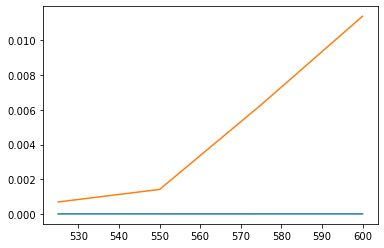

In [25]:
plt.plot(meoh_slope_dict.keys(), meoh_slope_dict.values())
plt.plot(meoh_rates_tof.keys(), meoh_rates_tof.values())

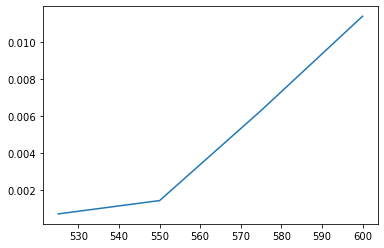

In [26]:
plt.plot(meoh_rates_tof.keys(), meoh_rates_tof.values())

In [27]:
surf_ROP_str = [i + " ROP [kmol/m^2 s]" for i in self.gas.species_names]



surf.kinetics_species_index(0, surf.phase_index(surf))

NameError: name 'self' is not defined

In [31]:
surf.kinetics_species_index(0, surf.phase_index(surf))

11

In [30]:
dir(surf)

['DP',
 'DPX',
 'DPY',
 'HP',
 'HPX',
 'HPY',
 'ID',
 'P',
 'P_sat',
 'SP',
 'SPX',
 'SPY',
 'SV',
 'SVX',
 'SVY',
 'T',
 'TD',
 'TDX',
 'TDY',
 'TP',
 'TPX',
 'TPY',
 'T_sat',
 'UV',
 'UVX',
 'UVY',
 'X',
 'Y',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_check_kinetics_species_index',
 '_check_phase_index',
 '_check_reaction_index',
 '_full_states',
 '_init_cti_xml',
 '_init_parts',
 '_phase_indices',
 '_phase_slice',
 '_references',
 'activities',
 'activity_coefficients',
 'add_reaction',
 'add_species',
 'advance_coverages',
 'atomic_weight',
 'atomic_weights',
 'basis',
 'chemical_potentials',
 'concentrations',
